In [58]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Carregar os dados de treinamento e teste

In [59]:
# Carregar os dados de treinamento e teste
X_train = pd.read_csv('../Dados/RedesNeurais/X_train.csv')
y_train = pd.read_csv('../Dados/RedesNeurais/y_train.csv')
X_test = pd.read_csv('../Dados/RedesNeurais/X_test.csv')
y_test = pd.read_csv('../Dados/RedesNeurais/y_test.csv')
X_val = pd.read_csv('../Dados/RedesNeurais/X_val.csv')
y_val = pd.read_csv('../Dados/RedesNeurais/y_val.csv')

# Converter y_train e y_test em vetores 1D
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_val = y_val.values.ravel()

## 2) Pré-processando dados

### 2.1) Configurando LabelEncoder

In [60]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

### 2.2) Corrigindo dados

In [61]:
# Padronizar as características (normalização)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Converter as classes em vetores one-hot (para a camada de saída)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## 3) Experimentando diferentes redes neurais

In [62]:
architectures = [
    (32, 32),        # Exemplo de arquitetura 1
    (64, 32, 16),    # Exemplo de arquitetura 2
    (128, 64),       # Exemplo de arquitetura 3
]

best_model = None
best_accuracy = 0.0
min_loss = 100

accuracies_train = []  
accuracies_test = [] 

### 3.1) Construindo redes neurais

In [63]:
for architecture in architectures:
    model = Sequential()
    for units in architecture:
        model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    train_accuracy = [acc * 100 for acc in history.history['accuracy']]
    _, test_accuracy = model.evaluate(X_test, y_test)
    accuracies_train.append(train_accuracy)
    accuracies_test.append(test_accuracy)

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Arquitetura {architecture}: Acurácia na validação: {accuracy * 100:.2f}%')
    print(f'Arquitetura {architecture}: Loss final: {loss * 100:.2f}%')
    print("----------------------------------------------------------------\n")

    if accuracy > best_accuracy and loss < min_loss:
        best_accuracy = accuracy
        best_model = model


5/5 [==============================] - 0s 1000us/step - loss: 0.2172 - accuracy: 0.9200
Arquitetura (32, 32): Acurácia na validação: 92.00%
Arquitetura (32, 32): Loss final: 21.72%
----------------------------------------------------------------

5/5 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.9200
Arquitetura (64, 32, 16): Acurácia na validação: 92.00%
Arquitetura (64, 32, 16): Loss final: 19.24%
----------------------------------------------------------------

5/5 [==============================] - 0s 1ms/step - loss: 0.1884 - accuracy: 0.9000
Arquitetura (128, 64): Acurácia na validação: 90.00%
Arquitetura (128, 64): Loss final: 18.84%
----------------------------------------------------------------



### 3.2) Plotando Diferenças

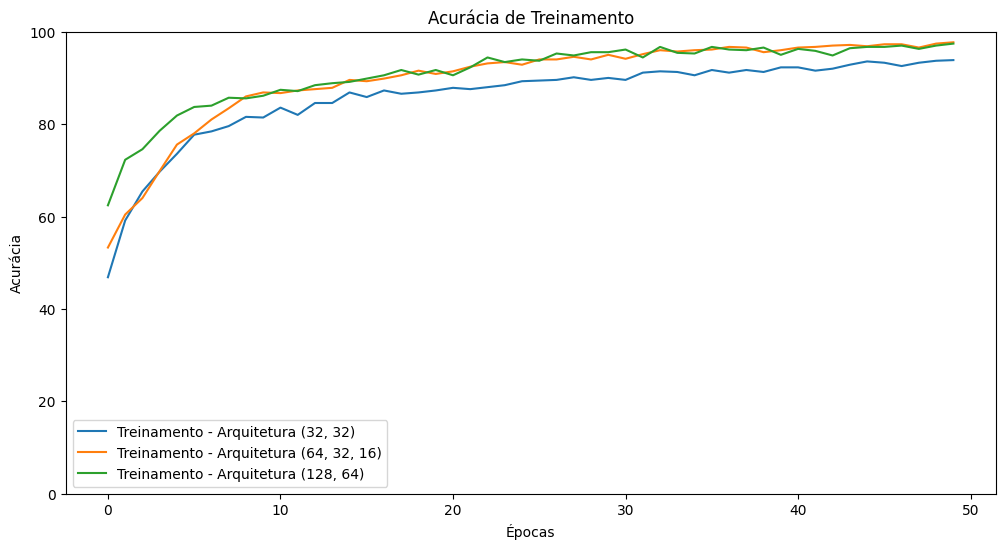

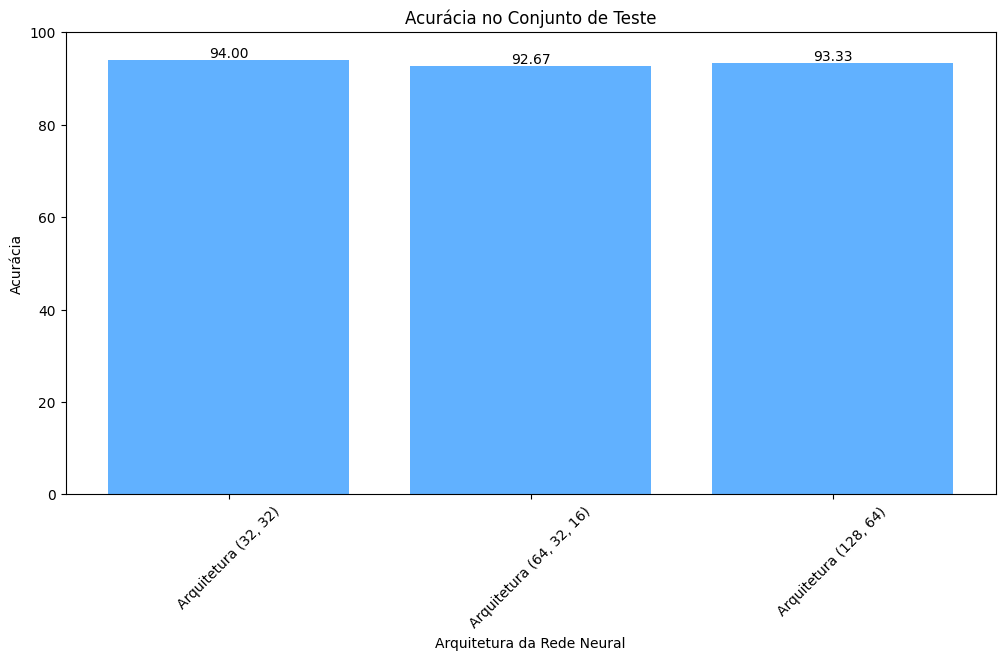

In [64]:
plt.figure(figsize=(12, 6))

for i, architecture in enumerate(architectures):
    plt.plot(accuracies_train[i], label=f'Treinamento - Arquitetura {architecture}')

plt.title('Acurácia de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.ylim(0, 100)

test_accuracies = [accuracy * 100 for accuracy in accuracies_test]
architecture_labels = [f'Arquitetura {architecture}' for architecture in architectures]

plt.figure(figsize=(12, 6))
plt.bar(architecture_labels, test_accuracies, color='dodgerblue', alpha=0.7)
plt.title('Acurácia no Conjunto de Teste')
plt.xlabel('Arquitetura da Rede Neural')
plt.ylabel('Acurácia')
plt.ylim(0, 100) 
plt.xticks(rotation=45)

# Adicionar os valores das barras
for i, v in enumerate(test_accuracies):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

### 4.3) Avaliando 

In [65]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

5/5 [==============================] - 0s 1ms/step - loss: 0.2605 - accuracy: 0.9400
Melhor modelo - Acurácia no conjunto de teste: 94.00%


## 5) Predição do melhor modelo

In [66]:
y_pred = best_model.predict(X_test)

5/5 [==============================] - 0s 750us/step


## 6) Matriz Confusão

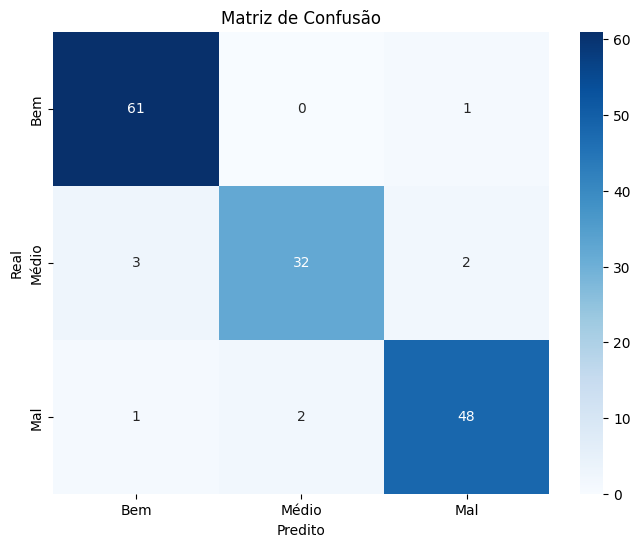

In [67]:
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## 7) Métricas de eficácia

In [68]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia no conjunto de teste: 94.00%
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        62
           1       0.94      0.86      0.90        37
           2       0.94      0.94      0.94        51

    accuracy                           0.94       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.94      0.94       150



## A) OBS: Rede Neural Unica

In [69]:
# Construir um modelo de rede neural
neuralNetwork = Sequential()
neuralNetwork.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
neuralNetwork.add(Dense(32, activation='relu'))
neuralNetwork.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes

neuralNetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

neuralNetwork.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = neuralNetwork.predict(X_test)

test_loss, test_accuracy = neuralNetwork.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

Epoch 1/100


22/22 [==============================] - 0s 857us/step - loss: 1.0153 - accuracy: 0.5429
Epoch 2/100
22/22 [==============================] - 0s 810us/step - loss: 0.8641 - accuracy: 0.6786
Epoch 3/100
22/22 [==============================] - 0s 809us/step - loss: 0.7467 - accuracy: 0.7114
Epoch 4/100
22/22 [==============================] - 0s 810us/step - loss: 0.6645 - accuracy: 0.7214
Epoch 5/100
22/22 [==============================] - 0s 762us/step - loss: 0.6132 - accuracy: 0.7357
Epoch 6/100
22/22 [==============================] - 0s 810us/step - loss: 0.5710 - accuracy: 0.7743
Epoch 7/100
22/22 [==============================] - 0s 762us/step - loss: 0.5370 - accuracy: 0.7900
Epoch 8/100
22/22 [==============================] - 0s 809us/step - loss: 0.5045 - accuracy: 0.8229
Epoch 9/100
22/22 [==============================] - 0s 762us/step - loss: 0.4764 - accuracy: 0.8271
Epoch 10/100
22/22 [==============================] - 0s 810us/step - loss: 0.4519 - accuracy: 0.8443
E

## A.1) Matriz Confusão

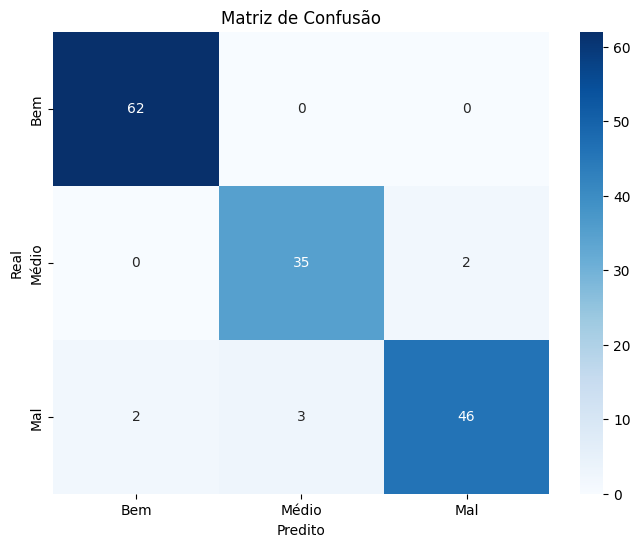

In [70]:
# Calcule a matriz de confusão
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  # Substitua y_test e y_pred pelos seus dados reais e previstos

# Crie uma visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## A.2) Métricas de eficácia

In [71]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia no conjunto de teste: 95.33%
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        62
           1       0.92      0.95      0.93        37
           2       0.96      0.90      0.93        51

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

